In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funcs.ad import aggregate_pvalues, get_sigma_values

In [97]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv("../results/params_of_star_planet_systems_with_AD_tests.csv")

# rename column tic_id to TIC
sps_w_ad.rename(columns={"tic_id": "TIC"}, inplace=True)

sps_w_ad_rv = pd.read_csv("../data/2022_11_15_input_catalog_NONtransit_star_planet_systems.csv")

# concat the two tables
sps_w_ad = pd.concat([sps_w_ad, sps_w_ad_rv], axis=0)

# read in age and rotation period from the literature search
literature_params = pd.read_csv("../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

# aggregate the p-values
mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period="orbit")
print(mean_std.shape)
# merge the AD test results with the stellar parameters
mean_std = mean_std.merge(literature_params, on=["TIC"], how="left")
print(mean_std.shape)


(36, 4)
(36, 18)


Kepler-1627
Kepler-1646
HIP 67522
KOI-12
TOI-540
DS Tuc A
K2-25
TAP 26
AU Mic
TOI-837
TIC 67646988


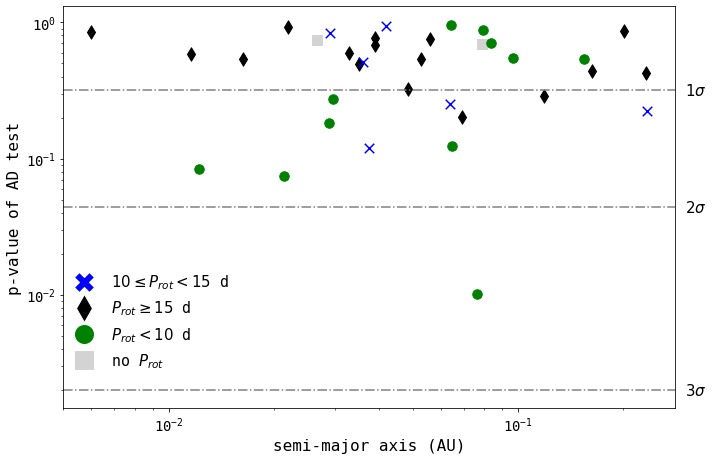

In [99]:

from matplotlib.lines import Line2D

sigmas, sigma_labels = get_sigma_values()

legend = [Line2D([0], [0], marker='X', color='w', label=r"$10 \leq P_{rot} < 15$ d", markerfacecolor='blue', markersize=10),
            Line2D([0], [0], marker='d', color='w', label=r"$P_{rot} \geq 15$ d", markerfacecolor='black', markersize=10),
            Line2D([0], [0], marker='o', color='w', label=r"$P_{rot} < 10$ d", markerfacecolor='green', markersize=10),    
            Line2D([0], [0], marker='s', color='w', label=r"no $P_{rot}$", markerfacecolor='lightgrey', markersize=10)]
labels = [r"$10 \leq P_{rot} < 15$ d", r"$P_{rot} \geq 15$ d", r"$P_{rot} < 10$ d", "no $P_{rot}$"]

fig, ax = plt.subplots(figsize=(10,6.5))
for i, row in mean_std.iterrows():
    # try:
    a = sps_w_ad[sps_w_ad.TIC.astype(str) == str(row.TIC)].pl_orbsmax.values[0]
    st_rotp = row.st_rotp
    hostname = sps_w_ad[sps_w_ad.TIC.astype(str) == str(row.TIC)].hostname.values[0]
    
    if type(hostname) == float:
        hostname = f"TIC {row.TIC}"

    if st_rotp < 10.:
        color = "green"
        symbol = "o"
        print(hostname)
    elif (st_rotp >= 10.) & (st_rotp < 15.):
        color = "blue"
        symbol = "x"
    elif (st_rotp >= 15.):
        color = "black"
        symbol = "d"
    else:
        color = "lightgrey"
        symbol = "s"
    

    plt.scatter(a, row["mean"], marker=symbol,     
        c=color, s=90, alpha=1.)
    # plt.text(a*1.02, row["mean"]*.9, fr"{hostname}, {row.number_of_flares}", fontsize=8, color="k",
    #     horizontalalignment='left', verticalalignment='center', rotation=0)

plt.yscale("log")
plt.xscale("log")


for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(.3, sigma, label, fontsize=15, color="k", verticalalignment="center")

plt.ylabel("p-value of AD test")
plt.xlabel("semi-major axis (AU)")
# plt.xlabel("orbital period (days)")
plt.legend(legend,labels,loc=(0,0.08), fontsize=15)

# Compare to fake p-value calculations

In [ ]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# get different modes
modes = adtests["period"].unique()

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv("../results/params_of_star_planet_systems_with_AD_tests.csv")

# read in age and rotation period from the literature search
literature_params = pd.read_csv("../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

res = pd.DataFrame()
print(res.shape)
# aggregate the p-values
for mode in modes:
    
    mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period=mode)
    print(mode)

    mean_std = mean_std[["TIC","mean"]]
    
    if res.shape[0] == 0:
        res = mean_std.set_index("TIC")
    else:
        # join the the table to res as a new column
        res = res.merge(mean_std, on="TIC", how="left")

    res = res.rename(columns={"mean": f"mean_{mode}"})

# merge the AD test results with the stellar parameters
res = res.merge(literature_params, on=["TIC"], how="left")


In [ ]:
res.columns

In [ ]:
plt.figure(figsize=(9,6.5))

for mode in modes:
    if mode == "orbit":
        o = 10
        histtype = "bar"
    else:
        o = 1
        histtype="step"
    plt.hist(res[f"mean_{mode}"], bins=np.logspace(-3,0,15), 
              label=mode.replace("_"," "), linewidth=3,zorder=o,alpha=.5, histtype=histtype)

plt.xscale("log")
plt.legend(loc=2)
plt.xlabel("p-value of AD test")
plt.ylabel("number of stars")